<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models with Player Track Box Score Stats Features</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Baseline-Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

# Data

[Return to top](#Baseline-Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_rolling_player_track_box_stats_2021_2024_r10.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.tail()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-03,19.099,24.0,53.0,75.2,409.3,3.5,2.2,285.6,30.1,20.0,37.7,0.527,22.6,52.3,0.434,0.474,20.9,32.3,0.645,114.0,18.119,21.8,56.4,76.5,418.0,2.9,2.6,298.0,26.7,17.1,35.9,0.478,24.8,51.9,0.477,0.478,16.6,26.0,0.657,114.1,218
2024-02-04,18.583,22.9,54.3,74.6,413.2,5.3,2.7,292.0,30.0,19.9,36.5,0.557,22.5,54.8,0.412,0.465,22.9,35.2,0.654,113.3,17.351,19.3,52.9,70.2,390.6,6.5,1.5,272.0,26.8,19.4,33.1,0.588,26.7,51.6,0.520,0.547,18.0,27.2,0.679,122.3,252
2024-02-04,18.315,23.1,54.4,75.7,384.4,3.8,2.5,263.3,28.0,18.5,36.3,0.509,24.6,53.1,0.462,0.480,21.9,31.6,0.696,115.5,18.413,26.1,54.9,79.1,396.3,1.7,3.0,276.4,25.0,16.4,32.6,0.501,23.5,52.3,0.447,0.470,19.0,28.6,0.672,110.6,210
2024-02-04,18.729,23.1,52.3,73.8,406.7,2.2,2.6,288.7,23.2,16.6,34.4,0.496,21.7,53.2,0.407,0.437,19.7,29.3,0.676,102.8,18.976,28.5,53.9,79.9,434.7,3.2,2.5,312.1,29.8,17.7,36.1,0.492,26.5,56.3,0.478,0.482,20.0,30.7,0.662,116.2,214
2024-02-04,18.009,25.1,62.3,85.2,392.3,2.9,2.0,271.0,25.0,16.8,31.5,0.527,26.3,59.5,0.440,0.474,18.0,28.7,0.641,121.5,18.313,24.7,54.6,77.5,409.6,4.2,1.4,290.1,27.1,16.1,33.9,0.473,23.4,52.2,0.448,0.458,20.5,32.5,0.631,110.1,222


In [5]:
pm_scaled_df.head()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,18.59,24.0,54.0,74.0,408.0,3.0,3.0,281.0,25.0,24.0,47.0,0.511,21.0,46.0,0.457,0.484,16.0,21.0,0.762,121.0,17.73,14.0,65.0,77.0,421.0,3.0,2.0,296.0,31.0,13.0,27.0,0.481,29.0,59.0,0.492,0.488,10.0,24.0,0.417,115.0,29.0
2021-10-23,18.23,25.0,61.0,86.0,384.0,1.0,4.0,250.0,26.0,14.0,29.0,0.483,28.0,58.0,0.483,0.483,25.0,42.0,0.595,124.0,18.23,32.0,43.0,71.0,397.0,2.0,4.0,281.0,26.0,19.0,40.0,0.475,23.0,47.0,0.489,0.483,20.0,24.0,0.833,112.0,7.0
2021-10-23,18.26,27.0,48.0,71.0,425.0,1.0,3.0,285.0,32.0,20.0,36.0,0.556,29.0,62.0,0.468,0.500,17.0,30.0,0.567,123.0,18.57,27.0,55.0,79.0,384.0,3.0,1.0,263.0,19.0,15.0,28.0,0.536,17.0,56.0,0.304,0.381,18.0,22.0,0.818,95.0,-10.0
2021-10-23,18.99,32.0,52.0,83.0,417.0,3.0,2.0,282.0,14.0,18.0,49.0,0.367,12.0,48.0,0.250,0.309,25.0,32.0,0.781,83.0,17.92,25.0,56.0,79.0,406.0,1.0,1.0,279.0,16.0,9.0,33.0,0.273,22.0,60.0,0.367,0.333,12.0,20.0,0.600,87.0,-8.0
2021-10-24,17.74,24.0,62.0,80.0,389.0,3.0,0.0,259.0,29.0,23.0,46.0,0.500,25.0,49.0,0.510,0.505,15.0,32.0,0.469,124.0,20.49,41.0,55.0,92.0,484.0,7.0,3.0,327.0,34.0,12.0,30.0,0.400,36.0,87.0,0.414,0.410,23.0,32.0,0.719,134.0,-10.0


In [6]:
res_scaled_df.tail()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-03,19.099,24.0,53.0,75.2,409.3,3.5,2.2,285.6,30.1,20.0,37.7,0.527,22.6,52.3,0.434,0.474,20.9,32.3,0.645,114.0,18.119,21.8,56.4,76.5,418.0,2.9,2.6,298.0,26.7,17.1,35.9,0.478,24.8,51.9,0.477,0.478,16.6,26.0,0.657,114.1,0
2024-02-04,18.583,22.9,54.3,74.6,413.2,5.3,2.7,292.0,30.0,19.9,36.5,0.557,22.5,54.8,0.412,0.465,22.9,35.2,0.654,113.3,17.351,19.3,52.9,70.2,390.6,6.5,1.5,272.0,26.8,19.4,33.1,0.588,26.7,51.6,0.520,0.547,18.0,27.2,0.679,122.3,0
2024-02-04,18.315,23.1,54.4,75.7,384.4,3.8,2.5,263.3,28.0,18.5,36.3,0.509,24.6,53.1,0.462,0.480,21.9,31.6,0.696,115.5,18.413,26.1,54.9,79.1,396.3,1.7,3.0,276.4,25.0,16.4,32.6,0.501,23.5,52.3,0.447,0.470,19.0,28.6,0.672,110.6,0
2024-02-04,18.729,23.1,52.3,73.8,406.7,2.2,2.6,288.7,23.2,16.6,34.4,0.496,21.7,53.2,0.407,0.437,19.7,29.3,0.676,102.8,18.976,28.5,53.9,79.9,434.7,3.2,2.5,312.1,29.8,17.7,36.1,0.492,26.5,56.3,0.478,0.482,20.0,30.7,0.662,116.2,0
2024-02-04,18.009,25.1,62.3,85.2,392.3,2.9,2.0,271.0,25.0,16.8,31.5,0.527,26.3,59.5,0.440,0.474,18.0,28.7,0.641,121.5,18.313,24.7,54.6,77.5,409.6,4.2,1.4,290.1,27.1,16.1,33.9,0.473,23.4,52.2,0.448,0.458,20.5,32.5,0.631,110.1,1


# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [8]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

In [9]:
# configuration for total points with expanding window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
lr, model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    fitted_model=True
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 7.73 seconds


In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.12
- Null RMSE: 20.28


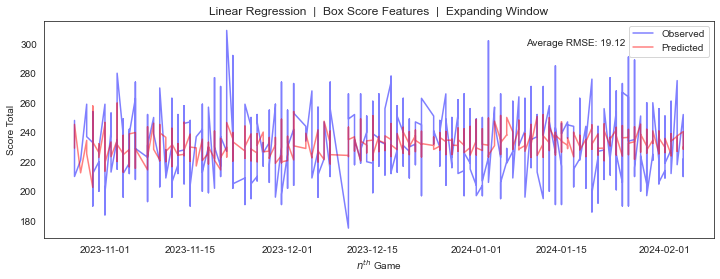

In [11]:
utl.plot_model_performance(
    title='Linear Regression  |  Box Score Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [12]:
# configuration for total points with rolling window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 17.71 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.44
- Null RMSE: 19.88


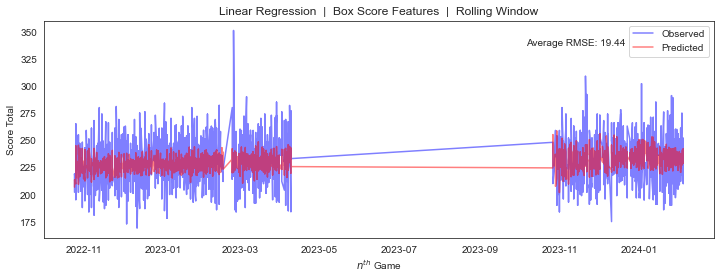

In [14]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Box Score Features  |  Rolling Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [15]:
# configuration for point difference with expanding window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 8.58 seconds


In [16]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.34
- Null RMSE: 15.32


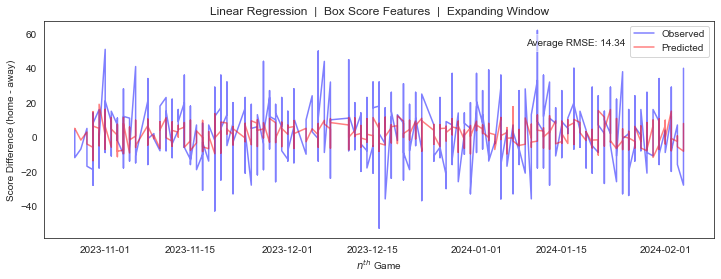

In [17]:
utl.plot_model_performance(
    title='Linear Regression  |  Box Score Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [18]:
# configuration for points difference with rolling window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 18.07 seconds


In [19]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.84
- Null RMSE: 14.28


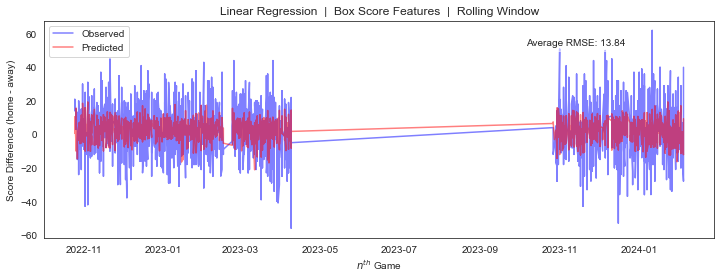

In [20]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Box Score Features  |  Rolling Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [21]:
# configuration for game winner with expanding window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 231.40 seconds


In [22]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.66
- Overall AUC: 0.70
- Average F1 Score: 0.71


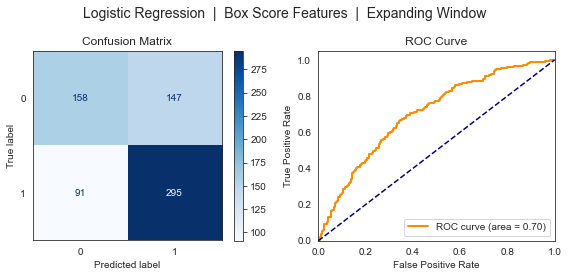

In [23]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Box Score Features  |  Expanding Window'
)

In [24]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/GLM_preds_playertrack_stats.csv', index=False)

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [25]:
# configuration for game winner with rolling window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit,
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 629.89 seconds


In [26]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.61
- Overall AUC: 0.64
- Average F1 Score: 0.69


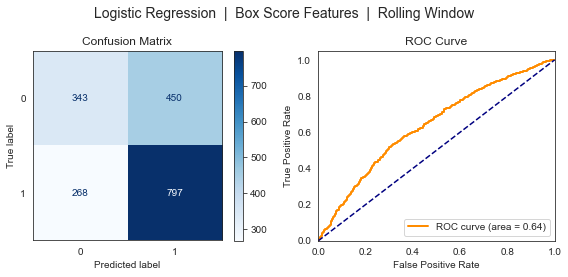

In [27]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Box Score Features  |  Rolling Window'
)